In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from typing import TypedDict, Literal, Annotated
from dotenv import load_dotenv

In [2]:
load_dotenv()  # take environment variables from .env file

True

In [11]:
# post evaluation schema
from pydantic import BaseModel, Field
class PostEvaluation(BaseModel):
    sentiment: Annotated[Literal["approved", "need_revision"], Field(description="The condition of the given post.")]
    feedback: Annotated[str, Field(description="Constructive feedback on the post.")]

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.5)
structured_llm = llm.with_structured_output(PostEvaluation)

In [12]:
# Define the state structure
class PostState(TypedDict):
    topic: str
    style: Literal["formal", "informal", "humorous", "serious"]
    post: str
    feedback: list[str]
    evaluation: Literal["approved", "needs_revision"]
    iteration: int
    max_iterations: int

In [16]:
# Functions for each node 
def generate_post(state: PostState):
    # prompt
    message = [
        SystemMessage(content="You are a creative social media post generator."),
        HumanMessage(content=f"""Create a {state['style']} post about '{state['topic']}'.
        Rules:
        - Keep it under 280 characters.
        - Use observational humor
        - Use simple like day-to-day language."""),
    ]
    response = llm.invoke(message).content
    return {"post": response}

# creating th evaluation function
def evaluate_post(state: PostState):
    message = [
        SystemMessage(content="You are a social media content evaluator."),
        HumanMessage(content=f"""Evaluate the following post for its effectiveness and engagement potential:
        Post: "{state['post']}"
        Provide feedback on what works well and what could be improved according to the given criteria:
        - Relevance to the topic '{state['topic']}'
        - Originality and creativity
        - Humor and tone
        
        Finally, decide if the post is 'approved' or 'needs_revision'.""")
    ]
    response = structured_llm.invoke(message)
    return {"evaluation": response.sentiment, "feedback": response.feedback}

# creating the revision function
def revise_post(state: PostState):
    message = [
        SystemMessage(content="You are a social media post reviser."),
        HumanMessage(content=f"""Revise the following post based on the feedback provided:
        Original Post: "{state['post']}"
        Feedback: "{state['feedback'][-1]}"
        Topic: '{state['topic']}'
        """)
    ]

    response = llm.invoke(message).content
    iteration = state['iteration'] + 1
    return {"post": response, "iteration": iteration}

In [21]:
# route evaluation results
def route_evaluation(state: PostState):
    if state['evaluation'] == "approved" or state['iteration'] >= state['max_iterations']:
        return "approved"
    else:
        return "revise_post"

In [22]:
# Defining the Graph
graph = StateGraph(PostState)

graph.add_node("generate", generate_post)
graph.add_node("evaluate", evaluate_post)
graph.add_node("revise", revise_post)

# Defining the edges
graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")
graph.add_conditional_edges("evaluate", route_evaluation,{"approved": END, "revise_post": "revise"})
graph.add_edge("revise", "evaluate")

# compile the graph
workflow = graph.compile()


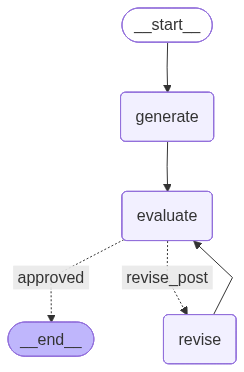

In [23]:
workflow

In [24]:
# Inital State
initial_state: PostState = {
    "topic": "The impact of technology on modern communication",
    "style": "humorous",
    "post": "",
    "feedback": [],
    "evaluation": "needs_revision",
    "iteration": 0,
    "max_iterations": 3,
}

In [25]:
workflow.invoke(initial_state)

{'topic': 'The impact of technology on modern communication',
 'style': 'humorous',
 'post': 'We\'re all sitting together, scrolling separately. Then someone says, "Did you see that meme I just sent you?" Peak modern communication. 📱😂',
 'feedback': "This post is highly effective and engaging. It perfectly captures a common and relatable modern communication paradox caused by technology, making it very relevant to the topic. The humor is subtle and effective, and the tone is lighthearted, enhanced by the emojis. It's concise, original, and likely to resonate well with an audience.",
 'evaluation': 'approved',
 'iteration': 0,
 'max_iterations': 3}